# Introduction

In this notebook, mixup and label smoothing is applied in compairsion with the previous resnet-50 final model. Where we can see that the top-1 accuracy increases with less training time. 

Please note that the model is only trainined with 224 image sizes, with top-1 accuracy beyong 87%, where the resnet-50 model will need another 6 hours training on P100 GPU to reach 88% accuracy with same data / argumentation (besides mixup) 

Also, the mixup - label smoothing model is still under fit, it can also be trained longer for better top 1 accuracy. 

In [1]:
from fastai import *
from fastai.vision import *
import pandas as pd

In [2]:
path = Path('/home/jupyter/.fastai/data/food-101/food-101')
df_test = pd.read_csv(path/'test.csv')
data = (ImageList
        .from_csv(path,'total-train-20split-seed47.csv',folder='images')
        .split_from_df(col='is_valid')
        .label_from_df(cols='label')
        .transform(get_transforms(),size=224)
        .add_test(ImageList.from_df(df_test,path=path/'images',cols='fn'))
        .databunch(bs=64,num_workers=8)
        .normalize(imagenet_stats)
)

In [3]:
loss_func = LabelSmoothingCrossEntropy()

In [4]:
learn = cnn_learner(data,models.resnet50,metrics=[accuracy,top_k_accuracy],loss_func = loss_func).mixup()

In [5]:
learn.load('res50-stage-2-224-seed47');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 4.79E-03


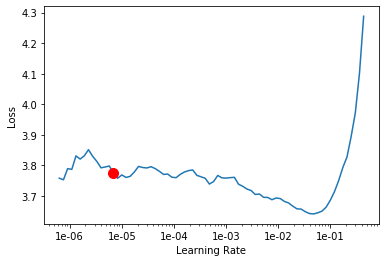

In [6]:
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [7]:
lr = 5e-3

In [8]:
learn.fit_one_cycle(6,slice(lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.495090,1.715276,0.751221,0.918944,07:49
1,2.541132,1.725814,0.742970,0.915314,04:41
2,2.484745,1.680782,0.750891,0.919010,04:39
3,2.437394,1.654252,0.764422,0.923432,04:39
4,2.376415,1.623605,0.769307,0.927591,04:39
5,2.334229,1.618652,0.772013,0.928251,04:40


In [9]:
learn.save('stage-1-224-mixup')

In [10]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


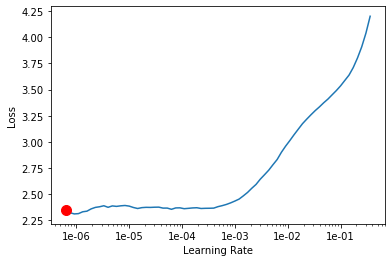

In [15]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


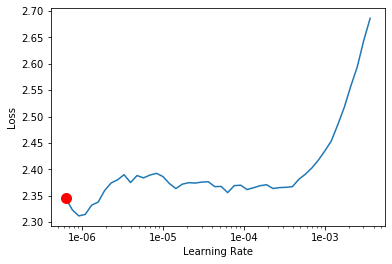

In [19]:
# learn.recorder.plot(suggestion=True,skip_end=30)

In [11]:
learn.fit_one_cycle(10,slice(1e-5/2,lr/5))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.349976,1.610892,0.769307,0.927657,05:43
1,2.376144,1.629635,0.760264,0.925677,05:43
2,2.369999,1.614503,0.762706,0.928647,05:42
3,2.314137,1.569167,0.774323,0.930297,05:43
4,2.274899,1.534281,0.783366,0.934653,05:42
5,2.181320,1.487489,0.797624,0.940594,05:42
6,2.114175,1.460988,0.806535,0.941980,05:43
7,2.059639,1.438630,0.812013,0.944686,05:43
8,2.030539,1.427962,0.815578,0.945082,05:43
9,2.019228,1.428776,0.815644,0.944092,05:42


In [12]:
learn.save('stage-2-224-mixup')

In [13]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)

In [23]:
preds.shape

torch.Size([25250, 101])

In [14]:
def prepare_output(learn):
    ground_truth = []
    for item in learn.data.test_ds.x.items:
        ground_truth.append(data.classes.index(Path(item).parent.name))
    return ground_truth

In [17]:
gt = prepare_output(learn)
accuracy(preds,tensor(gt)),top_k_accuracy(preds,tensor(gt))

(tensor(0.8716), tensor(0.9753))

# Fin
The result in compairson with Resnet-50 final model without mixup and label smoothing has been improved by almost 2%, and it is very close to the fine tuned model with size 224. (88.3%)

Where the fine tuned resize model with size 224 requires another 6 hours training with 8CPUs with P100 GPU.

The top-1 accuracy can be further pushed beyond 88.3% if we train the dataset on 224 image size. 



# Conclusion
* In the dataset description, we know that the training set contains noisy label for each classes, thus, with label smoothing, we are regularizing the model to be not over-confident about the prediction. 

* Mixup also helps the model to be not overfit, as we can see from the resnet-50 final model, the model converges or at the edge of overfitting. But we can see the result with mixup, the model is still under fitting, thus, we can train more epochs on to obtain better accuracy. 